# Importing libraries

In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup

import json
from pandas.io.json import json_normalize 

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN 
from sklearn import preprocessing
import sklearn.utils
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn import decomposition

%matplotlib inline 
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

#!conda install -c conda-forge folium=0.5.0 --yes
import folium

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim

import datetime

# Data visualization

__Reading the saved dataframes from the ETL notebook__

In [19]:
df_hospitals = pd.read_csv('Data/df_hospitals.csv')
df_cases = pd.read_csv('Data/df_cases.csv')
df_cases_all = pd.read_csv('Data/df_cases_all.csv')

In [20]:
print(len(df_hospitals))
print(len(df_cases))
print(len(df_cases_all))

2461
67966
80407


__I will drop Hawai and Alaska just to focus the analysis of the data on the main land. Then resave the dataframes__

In [21]:
df_hospitals = df_hospitals[(df_hospitals['state_abb'] != 'HI') & (df_hospitals['state_abb'] != 'AK')]
df_hospitals.reset_index(drop=True, inplace=True)
df_hospitals.to_csv('Data/df_hospitals.csv', index=False)
df_hospitals

,county_id,county_id2,county,state,state_abb,num_licensed_beds,num_staffed_beds,num_icu_beds,adult_icu_beds,pedi_icu_beds,bed_utilization,extra_beds,avg_vent_usage,num_hospitals,population,Latitude,Longitude
0,0500000US01001,1001.0,Autauga,Alabama,AL,85.0,55.0,6,6,0.0,0.623113,30,2.0,1,55601.0,32.532237,-86.646440
1,0500000US01003,1003.0,Baldwin,Alabama,AL,386.0,362.0,51,51,0.0,0.563699,24,8.0,4,218022.0,30.659218,-87.746067
2,0500000US01005,1005.0,Barbour,Alabama,AL,74.0,30.0,5,5,0.0,0.430640,44,2.0,1,24881.0,31.870253,-85.405104
3,0500000US01007,1007.0,Bibb,Alabama,AL,35.0,25.0,4,4,0.0,0.376219,10,1.0,1,22400.0,33.015893,-87.127148
4,0500000US01009,1009.0,Blount,Alabama,AL,25.0,25.0,6,6,0.0,0.499069,0,2.0,1,57840.0,33.977358,-86.566440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2456,0500000US56037,56037.0,Sweetwater,Wyoming,WY,115.0,74.0,13,13,0.0,0.108408,41,2.0,2,43051.0,41.660328,-108.875677
2457,0500000US56039,56039.0,Teton,Wyoming,WY,48.0,48.0,6,6,0.0,0.319578,0,2.0,1,23081.0,44.048662,-110.426087
2458,0500000US56041,56041.0,Uinta,Wyoming,WY,225.0,105.0,6,6,0.0,0.450803,120,2.0,2,20299.0,41.284726,-110.558947
2459,0500000US56043,56043.0,Washakie,Wyoming,WY,18.0,18.0,3,3,0.0,0.287976,0,2.0,1,7885.0,43.878831,-107.669052


In [22]:
df_cases = df_cases[(df_cases['state_abb'] != 'HI') & (df_cases['state_abb'] != 'AK')]
df_cases.reset_index(drop=True, inplace=True)
df_cases['date'] = pd.to_datetime(df_cases['date']) #converting the dates to timestamps
df_cases.to_csv('Data/df_cases.csv', index=False)
df_cases


,date,county_id,county_id2,county,state,state_abb,cases,deaths,num_licensed_beds,num_staffed_beds,num_icu_beds,adult_icu_beds,pedi_icu_beds,bed_utilization,extra_beds,avg_vent_usage,num_hospitals,population,Latitude,Longitude
0,2020-01-21,0500000US53061,53061.0,Snohomish,Washington,WA,1,0,993.0,863.0,72.0,72.0,38.0,0.566322,130.0,25.0,5.0,814901.0,48.070464,-121.936784
1,2020-01-22,0500000US53061,53061.0,Snohomish,Washington,WA,1,0,993.0,863.0,72.0,72.0,38.0,0.566322,130.0,25.0,5.0,814901.0,48.070464,-121.936784
2,2020-01-23,0500000US53061,53061.0,Snohomish,Washington,WA,1,0,993.0,863.0,72.0,72.0,38.0,0.566322,130.0,25.0,5.0,814901.0,48.070464,-121.936784
3,2020-01-24,0500000US17031,17031.0,Cook,Illinois,IL,1,0,18546.0,15382.0,2021.0,2021.0,651.0,0.501626,3164.0,455.0,68.0,5180493.0,41.894294,-87.645455
4,2020-01-24,0500000US53061,53061.0,Snohomish,Washington,WA,1,0,993.0,863.0,72.0,72.0,38.0,0.566322,130.0,25.0,5.0,814901.0,48.070464,-121.936784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67961,2020-04-22,0500000US51199,51199.0,York,Virginia,VA,43,1,195.0,189.0,16.0,16.0,0.0,0.609943,6.0,5.0,2.0,67846.0,37.219081,-76.561648
67962,2020-04-22,0500000US48503,48503.0,Young,Texas,TX,4,1,50.0,50.0,8.0,8.0,0.0,0.279945,0.0,3.0,2.0,18045.0,33.158778,-98.678390
67963,2020-04-22,0500000US06115,6115.0,Yuba,California,CA,16,1,221.0,149.0,24.0,24.0,6.0,0.707348,72.0,12.0,1.0,78041.0,39.270130,-121.344259
67964,2020-04-22,0500000US04027,4027.0,Yuma,Arizona,AZ,28,1,456.0,447.0,42.0,42.0,20.0,0.585519,9.0,7.0,2.0,212128.0,32.773942,-113.910905


In [23]:
df_cases_all['date'] = pd.to_datetime(df_cases_all['date']) #converting the dates to timestamps

__Get the geographical location of the USA__

In [6]:
address = 'USA'
geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of USA are {}, {}.'.format(latitude, longitude))

/Users/mohab1/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Using Nominatim with the default "geopy/1.21.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  


The geograpical coordinate of USA are 39.7837304, -100.4458825.


__Due to an encoding problem in the original file of the geographical boundaries of US counties, the following piece of code from https://eric.clst.org was used to encode the file correctly__

In [7]:
# import os
# us_county_path = 'Data/gz_2010_us_050_00_500k.json'
# cur_json = json.load(open(us_county_path, encoding='ISO-8859-1'))
# path,ext = os.path.splitext(us_county_path)
# new_path =path+"_new"+ext
# with open(new_path,"w", encoding='utf-8') as jsonfile:
#         json.dump(cur_json,jsonfile,ensure_ascii=False)

__Visualizing the population in each US County with known hospital capacity__

In [ ]:
map_USA = folium.Map(location=[latitude, longitude], zoom_start=4)
USA_county_geo = 'Data/gz_2010_us_050_00_500k_new.json'
#threshold_scale = np.linspace(df_hospitals['population'].min(), df_hospitals['population'].max(), 6, dtype = int).tolist()
threshold_scale = list((df_hospitals['population'].quantile([0, 0.25, 0.5, 0.75, 1])).astype(int))
threshold_scale[-1] = threshold_scale[-1] + 1

map_USA.choropleth(
    geo_data=USA_county_geo,
    data=df_hospitals,
    columns=['county_id', 'population'],
    key_on='feature.properties.GEO_ID',
    threshold_scale = threshold_scale,
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Population in each US County with known hospital capacity'
)


for lat, lng, county, state, pop in zip(df_hospitals['Latitude'], df_hospitals['Longitude'], df_hospitals['county'], df_hospitals['state_abb'], df_hospitals['population']):
   label = '{}, {} - Population = {}'.format(county, state, pop)
   label = folium.Popup(label, parse_html=True)
   folium.CircleMarker(
       [lat, lng],
       radius=1,
       popup=label,
       color='blue',
       fill=False,
       fill_color='#3186cc',
       fill_opacity=0.0,
       line_opacity=0.0,
       parse_html=False).add_to(map_USA) 
    
map_USA

__Visualizing the number of known Hospitals in each US County__

In [ ]:
map_USA = folium.Map(location=[latitude, longitude], zoom_start=4)
USA_county_geo = 'Data/gz_2010_us_050_00_500k_new.json'
#threshold_scale = np.linspace(df_hospitals['num_hospitals'].min(), df_hospitals['num_hospitals'].max(), 6, dtype = int).tolist()
threshold_scale = list((df_hospitals['num_hospitals'].quantile([0, 0.25, 0.5, 0.75, 1])).astype(int))
threshold_scale[-1] = threshold_scale[-1] + 1

map_USA.choropleth(
    geo_data=USA_county_geo,
    data=df_hospitals,
    columns=['county_id', 'num_hospitals'],
    key_on='feature.properties.GEO_ID',
    threshold_scale = threshold_scale,
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Number of known Hospitals in each US County'
)
    
for lat, lng, county, state, hosp in zip(df_hospitals['Latitude'], df_hospitals['Longitude'], df_hospitals['county'], df_hospitals['state_abb'], df_hospitals['num_hospitals']):
   label = '{}, {} - Hospitals = {}'.format(county, state, hosp)
   label = folium.Popup(label, parse_html=True)
   folium.CircleMarker(
       [lat, lng],
       radius=1,
       popup=label,
       color='blue',
       fill=False,
       fill_color='#3186cc',
       fill_opacity=0.0,
       line_opacity=0.0,
       parse_html=False).add_to(map_USA) 
    
    
map_USA

## I will create and save two dataframes: 1) It will contain the total number of cases and deaths in each day (from day 1 of reported cases to the most recent day), 2) it will contain the most recent total number of cases and deaths in each US county with their hospital capacity

In [24]:
df_cases_date_total = df_cases_all[['date', 'cases', 'deaths']].groupby(by='date').sum().reset_index()
df_cases_date_total['dc_ratio'] = df_cases_date_total['deaths'] / df_cases_date_total['cases']

df_cases_date_total.to_csv('Data/df_cases_date_total.csv', index=False)
df_cases_date_total

,date,cases,deaths,dc_ratio
0,2020-01-21,1,0,0.000000
1,2020-01-22,1,0,0.000000
2,2020-01-23,1,0,0.000000
3,2020-01-24,2,0,0.000000
4,2020-01-25,3,0,0.000000
...,...,...,...,...
88,2020-04-18,726109,34655,0.047727
89,2020-04-19,751231,36057,0.047997
90,2020-04-20,778312,37742,0.048492
91,2020-04-21,803938,40262,0.050081


In [25]:
cols = df_cases.columns.tolist()
cols.remove('cases')
cols.remove('deaths')
cols.remove('date')
df_cases_county_total = df_cases.iloc[:,1:].groupby(by = cols).max().reset_index()
df_cases_county_total['dc_ratio'] = df_cases_county_total['deaths'] / df_cases_county_total['cases']

df_cases_county_total.to_csv('Data/df_cases_county_total.csv', index=False)
df_cases_county_total

,county_id,county_id2,county,state,state_abb,num_licensed_beds,num_staffed_beds,num_icu_beds,adult_icu_beds,pedi_icu_beds,bed_utilization,extra_beds,avg_vent_usage,num_hospitals,population,Latitude,Longitude,cases,deaths,dc_ratio
0,0500000US01001,1001.0,Autauga,Alabama,AL,85.0,55.0,6.0,6.0,0.0,0.623113,30.0,2.0,1.0,55601.0,32.532237,-86.646440,32,2,0.062500
1,0500000US01003,1003.0,Baldwin,Alabama,AL,386.0,362.0,51.0,51.0,0.0,0.563699,24.0,8.0,4.0,218022.0,30.659218,-87.746067,132,3,0.022727
2,0500000US01005,1005.0,Barbour,Alabama,AL,74.0,30.0,5.0,5.0,0.0,0.430640,44.0,2.0,1.0,24881.0,31.870253,-85.405104,29,0,0.000000
3,0500000US01007,1007.0,Bibb,Alabama,AL,35.0,25.0,4.0,4.0,0.0,0.376219,10.0,1.0,1.0,22400.0,33.015893,-87.127148,34,0,0.000000
4,0500000US01009,1009.0,Blount,Alabama,AL,25.0,25.0,6.0,6.0,0.0,0.499069,0.0,2.0,1.0,57840.0,33.977358,-86.566440,29,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2249,0500000US56033,56033.0,Sheridan,Wyoming,WY,88.0,71.0,12.0,12.0,0.0,0.183761,17.0,3.0,2.0,30233.0,44.781369,-106.881211,12,0,0.000000
2250,0500000US56037,56037.0,Sweetwater,Wyoming,WY,115.0,74.0,13.0,13.0,0.0,0.108408,41.0,2.0,2.0,43051.0,41.660328,-108.875677,10,0,0.000000
2251,0500000US56039,56039.0,Teton,Wyoming,WY,48.0,48.0,6.0,6.0,0.0,0.319578,0.0,2.0,1.0,23081.0,44.048662,-110.426087,63,0,0.000000
2252,0500000US56041,56041.0,Uinta,Wyoming,WY,225.0,105.0,6.0,6.0,0.0,0.450803,120.0,2.0,2.0,20299.0,41.284726,-110.558947,6,0,0.000000


# Data exploration

__First let's get the correlation between the cases and deaths in all counties. There is a high correlation. However the deaths/cases ratio show a weak correlation with the number of cases__

In [26]:
df_cases_date_total.corr()

,cases,deaths,dc_ratio
cases,1.000000,0.983054,0.600727
deaths,0.983054,1.000000,0.589557
dc_ratio,0.600727,0.589557,1.000000


__Plotting the total number of cases and deaths each day since day 1. You can see an exponentional increase in the number of cases till mid March and then the rate decreased slightly__

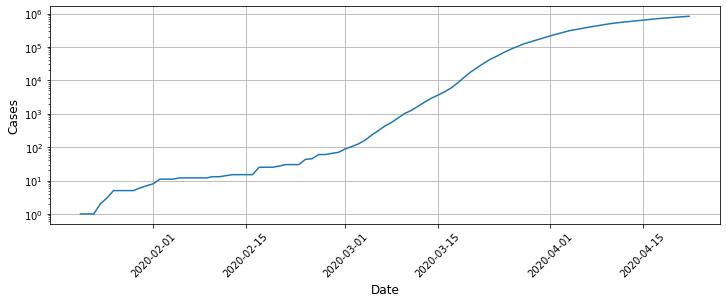

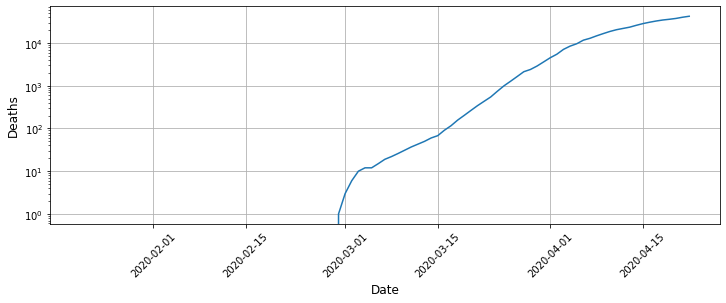

In [28]:
plt.figure(figsize = (12,4))
plt.semilogy(df_cases_date_total['date'], df_cases_date_total['cases'])
locs, labels = plt.xticks()            # Get locations and labels
#plt.xticks(np.arange(0, max(locs), step=7),  rotation=45)  # Set locations and labels
plt.xticks(rotation=45)
plt.grid()
plt.xlabel('Date', size=12)
plt.ylabel('Cases', size=12)
plt.show()

plt.figure(figsize = (12,4))
plt.semilogy(df_cases_date_total['date'], df_cases_date_total['deaths'])
locs, labels = plt.xticks()            # Get locations and labels
#plt.xticks(np.arange(0, max(locs), step=7),  rotation=45)  # Set locations and labels
plt.xticks(rotation=45)
plt.grid()
plt.xlabel('Date', size=12)
plt.ylabel('Deaths', size=12)
plt.show()

__Let's see the correlation between the hospital capacity in each county and the population. This should give us an idea about the preparedness of each county with respect to its population. You can see a high correlation which is expected and a good indication of preparedness.__

In [29]:
df_hospitals[['population', 'num_hospitals', 'num_licensed_beds', 'num_staffed_beds', 'bed_utilization', 'avg_vent_usage']].corr()

,population,num_hospitals,num_licensed_beds,num_staffed_beds,bed_utilization,avg_vent_usage
population,1.000000,0.917030,0.929207,0.944230,0.217963,0.912519
num_hospitals,0.917030,1.000000,0.952337,0.955904,0.196284,0.924735
num_licensed_beds,0.929207,0.952337,1.000000,0.988958,0.230387,0.965214
num_staffed_beds,0.944230,0.955904,0.988958,1.000000,0.225509,0.964205
bed_utilization,0.217963,0.196284,0.230387,0.225509,1.000000,0.245022
avg_vent_usage,0.912519,0.924735,0.965214,0.964205,0.245022,1.000000


__Regression plots of some of these correlations__

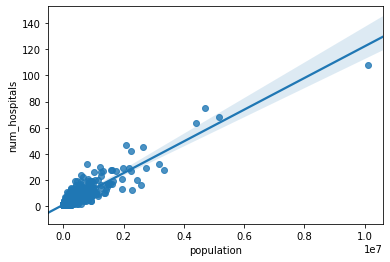

In [30]:
sns.regplot(x="population", y="num_hospitals", data=df_hospitals)

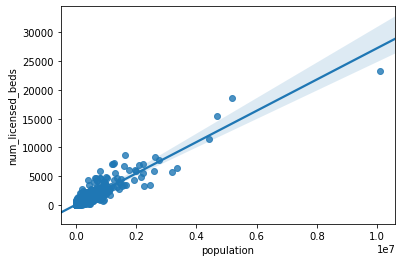

In [31]:
sns.regplot(x="population", y="num_licensed_beds", data=df_hospitals)

In [32]:
df_cases[(df_cases['county'] == 'Snohomish') & (df_cases['state_abb'] == 'WA')][['cases', 'deaths']].corr()

,cases,deaths
cases,1.000000,0.980535
deaths,0.980535,1.000000


__Considering the first county (Snohomish) to have reported covid 19 case, let's explore it more__ 

In [33]:
temp = df_cases[(df_cases['county'] == 'Snohomish') & (df_cases['state_abb'] == 'WA')][['date', 'cases', 'deaths']]

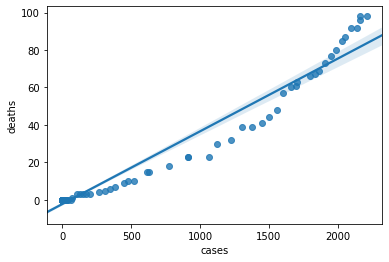

In [34]:
sns.regplot(x="cases", y="deaths", data=temp)

__Clearly non-linear increase__

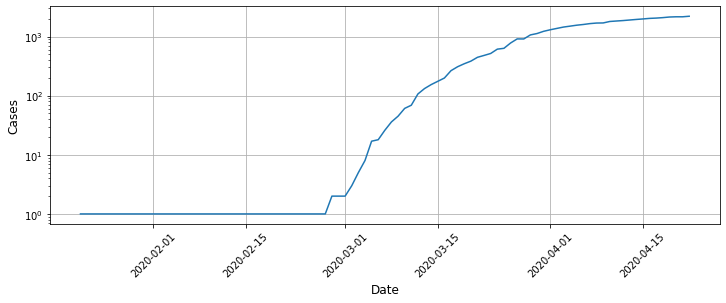

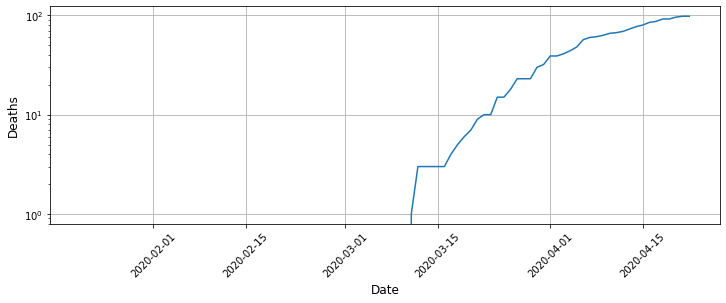

In [35]:
plt.figure(figsize = (12,4))
plt.semilogy(temp['date'], temp['cases'])
locs, labels = plt.xticks()            # Get locations and labels
#plt.xticks(np.arange(0, max(locs), step=7),  rotation=45)  # Set locations and labels
plt.xticks(rotation=45)
plt.grid()
plt.xlabel('Date', size=12)
plt.ylabel('Cases', size=12)
plt.show()

plt.figure(figsize = (12,4))
plt.semilogy(temp['date'], temp['deaths'])
locs, labels = plt.xticks()            # Get locations and labels
#plt.xticks(np.arange(0, max(locs), step=7),  rotation=45)  # Set locations and labels
plt.xticks(rotation=45)
plt.grid()
plt.xlabel('Date', size=12)
plt.ylabel('Deaths', size=12)
plt.show()

__Now let's see the correlation between the number of cases/death and the hospital capacity in each county. Surprisingly, there is a weak correlation as opposed to a negative correlation.__

In [36]:
df_cases_county_total[['cases', 'deaths', 'population', 'num_hospitals', 'num_licensed_beds', 'num_staffed_beds', 'bed_utilization', 'avg_vent_usage']].corr()

,cases,deaths,population,num_hospitals,num_licensed_beds,num_staffed_beds,bed_utilization,avg_vent_usage
cases,1.000000,0.977130,0.335036,0.326632,0.401532,0.395911,0.092228,0.424025
deaths,0.977130,1.000000,0.257847,0.251718,0.325312,0.317591,0.071711,0.345768
population,0.335036,0.257847,1.000000,0.919246,0.930220,0.945368,0.216070,0.913551
num_hospitals,0.326632,0.251718,0.919246,1.000000,0.952011,0.955838,0.193375,0.924434
num_licensed_beds,0.401532,0.325312,0.930220,0.952011,1.000000,0.989021,0.228710,0.965066
num_staffed_beds,0.395911,0.317591,0.945368,0.955838,0.989021,1.000000,0.223905,0.963869
bed_utilization,0.092228,0.071711,0.216070,0.193375,0.228710,0.223905,1.000000,0.243932
avg_vent_usage,0.424025,0.345768,0.913551,0.924434,0.965066,0.963869,0.243932,1.000000


__Let's plot regression plots of some of these correlations (excluding New York because it has the highest number of cases/deaths)__

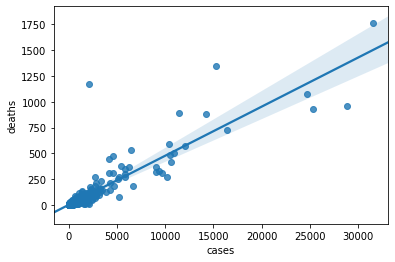

In [37]:
sns.regplot(x="cases", y="deaths", data=df_cases_county_total[df_cases_county_total['county_id'] != '0500000US36061'])

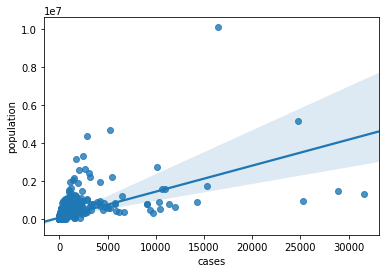

In [38]:
sns.regplot(x="cases", y="population", data=df_cases_county_total[df_cases_county_total['county_id'] != '0500000US36061'])

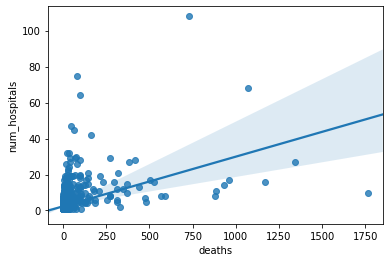

In [39]:
sns.regplot(x="deaths", y="num_hospitals", data=df_cases_county_total[df_cases_county_total['county_id'] != '0500000US36061'])

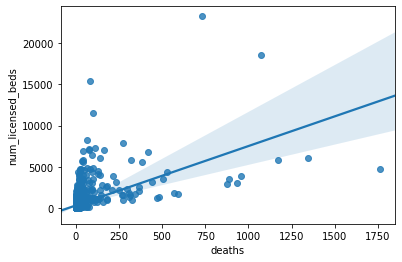

In [40]:
sns.regplot(x="deaths", y="num_licensed_beds", data=df_cases_county_total[df_cases_county_total['county_id'] != '0500000US36061'])

__Showing the top 5 counties in the number of cases and deaths. Surprisingly the two list differ in the last two counties inspite the strong correlation between cases and deaths__

In [41]:
df_cases_county_total.sort_values(by = 'deaths', ascending=False).head()

,county_id,county_id2,county,state,state_abb,num_licensed_beds,num_staffed_beds,num_icu_beds,adult_icu_beds,pedi_icu_beds,bed_utilization,extra_beds,avg_vent_usage,num_hospitals,population,Latitude,Longitude,cases,deaths,dc_ratio
1338,0500000US36061,36061.0,New York,New York,NY,8625.0,7454.0,944.0,944.0,460.0,0.503566,1171.0,211.0,28.0,1628701.0,40.776642,-73.970187,142442,10614,0.074515
1337,0500000US36059,36059.0,Nassau,New York,NY,4758.0,3598.0,334.0,334.0,237.0,0.702533,1160.0,173.0,10.0,1358343.0,40.729612,-73.589414,31555,1764,0.055902
960,0500000US26163,26163.0,Wayne,Michigan,MI,6053.0,5357.0,676.0,676.0,190.0,0.552590,696.0,209.0,27.0,1753893.0,42.284664,-83.261953,15276,1344,0.087981
1331,0500000US36047,36047.0,Kings,New York,NY,5838.0,4320.0,282.0,282.0,216.0,0.648280,1518.0,160.0,16.0,2582830.0,40.635045,-73.950640,2091,1170,0.559541
428,0500000US17031,17031.0,Cook,Illinois,IL,18546.0,15382.0,2021.0,2021.0,651.0,0.501626,3164.0,455.0,68.0,5180493.0,41.894294,-87.645455,24737,1072,0.043336


In [42]:
df_cases_county_total.sort_values(by = 'cases', ascending=False).head()

,county_id,county_id2,county,state,state_abb,num_licensed_beds,num_staffed_beds,num_icu_beds,adult_icu_beds,pedi_icu_beds,bed_utilization,extra_beds,avg_vent_usage,num_hospitals,population,Latitude,Longitude,cases,deaths,dc_ratio
1338,0500000US36061,36061.0,New York,New York,NY,8625.0,7454.0,944.0,944.0,460.0,0.503566,1171.0,211.0,28.0,1628701.0,40.776642,-73.970187,142442,10614,0.074515
1337,0500000US36059,36059.0,Nassau,New York,NY,4758.0,3598.0,334.0,334.0,237.0,0.702533,1160.0,173.0,10.0,1358343.0,40.729612,-73.589414,31555,1764,0.055902
1356,0500000US36103,36103.0,Suffolk,New York,NY,3882.0,3509.0,298.0,298.0,109.0,0.627793,373.0,132.0,17.0,1481093.0,40.943554,-72.692218,28854,959,0.033236
1362,0500000US36119,36119.0,Westchester,New York,NY,3014.0,2427.0,233.0,233.0,109.0,0.599209,587.0,69.0,14.0,967612.0,41.152686,-73.745753,25275,932,0.036874
428,0500000US17031,17031.0,Cook,Illinois,IL,18546.0,15382.0,2021.0,2021.0,651.0,0.501626,3164.0,455.0,68.0,5180493.0,41.894294,-87.645455,24737,1072,0.043336


__A histogram showing the average fatality rate over all the US counties. There are high rates (above >0.4 because of the low number of reported cases and high death rate).__

Average fatality rate:  0.03815467454103248


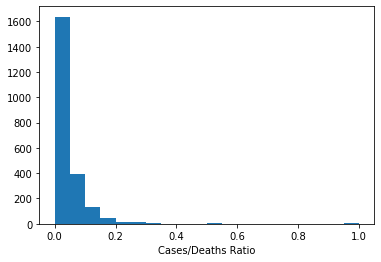

In [43]:
plt.hist(df_cases_county_total['dc_ratio'], bins = 20)
plt.xlabel('Cases/Deaths Ratio')
print('Average fatality rate: ', df_cases_county_total['dc_ratio'].mean())

__Visualizing the increase in the number of cases geographically over specific time_step (10 days here)__

In [ ]:
map_USA = folium.Map(location=[latitude, longitude], zoom_start=4)

time_step = 10
first_day = df_cases['date'].iloc[0] + pd.to_timedelta(0, unit='D')
last_day = df_cases['date'].iloc[-1] - pd.to_timedelta(0, unit='D')
time_index = np.arange(0,(last_day - first_day + pd.to_timedelta(1, unit='D')).days , time_step)

colo = plt.get_cmap('hot')(np.linspace(0.0, 1.0, len(time_index)))
colo_hex = []
for i in range(len(time_index)):
    colo_hex.append(colors.to_hex(colo[i]))
colo_hex = np.flip(colo_hex)
    
for step_count, i in enumerate(np.flip(time_index)):     
    date = first_day + pd.to_timedelta(i, unit='D')
    temp = df_cases[df_cases['date'] == date]
    print(date)
    

    for lat, lng, county, state, cases in zip(temp['Latitude'], temp['Longitude'], temp['county'], temp['state_abb'], temp['cases']):
        label = '{}, {} - Day = {}'.format(county, state, i)
        label = folium.Popup(label, parse_html=True)
        c= colo_hex[step_count]
        folium.CircleMarker(
           [lat, lng],
           radius=5,
           popup=label,
           color=c,
           fill=True,
           fill_color=c,
           fill_opacity=0.7,
           line_opacity=0.7
        ).add_to(map_USA) 

map_USA

In [230]:
#pca = decomposition.PCA(n_components=2)

In [231]:
#test = df_cases_county_total[['num_hospitals', 'num_licensed_beds', 'num_staffed_beds', 'avg_vent_usage']]

In [233]:
#print(pca.fit_transform(test))